<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Data exploration</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Data exploration, analysis

In [68]:
import _mypath
import os
import pandas as pd
import re
import fasttext
import spacy 
from functools import partial
import csv
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/input/data"

# Data loading

In [8]:
infile = os.path.join("../input/data/cleaned_merged_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")
print("data shape:", df.shape, end="\n\n")

df.head()

data shape: (105568, 8)



,Commentaire,star,date,client,reponse,source,company,langage
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr


# Data prep

## Cleaning (digits, max length 20, stops words, punctuations, lower case...)

In [9]:
nlp = spacy.load("fr_core_news_lg")

In [24]:
def clean(text, model):
    doc = model(text)
    tokens = []

    pattern_email = re.compile(r"[a-zA-Z0-9.-]+@[a-zA-Z.]+")
    pattern_url1 = re.compile(r"https?://[a-zA-Z0-9./]+")
    pattern_url2 = re.compile(r"www\.[a-zA-Z0-9.-:/]+")

    text = pattern_email.sub(" ", text)
    text = pattern_url1.sub(" ", text)
    text = pattern_url2.sub(" ", text)
    text = re.sub(r' {2,}', " ", text)

    for token in doc:
        if token.text.isnumeric(): continue
        if len(token.text)<2 or len(token.text)>20: continue
        if token.is_stop: continue
        if token.ent_type_ == "PUNCT": continue
        word = re.sub(r'[\@\#\$\*\-\=\+\~\|\°]', " ", token.text)
        word = re.sub(r' {2,}', " ", word)
        word = word.strip()
        if word:
            tokens += [word]

    return " ".join(tokens)

In [27]:
df["cleaned_review"] = df["Commentaire"].str.lower().map( (partial(clean, model=nlp)) )

In [33]:
df["star"].value_counts().sort_index()

star
1    24141
2     3607
3     6360
4    18427
5    53033
Name: count, dtype: int64

In [34]:
mapping = {1:"__label__NEGATIVE", 2:"__label__NEGATIVE", 
           3:"__label__NEUTRAL", 
           4:"__label__POSITIVE", 5:"__label__POSITIVE"}

df["Sentiment"] = df["star"].replace(mapping).astype(str)
df.head()

,Commentaire,star,date,client,reponse,source,company,langage,cleaned_review,Sentiment
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commandé mardi fevrier livraison jeudi m...,__label__NEGATIVE
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement site march...,__label__NEGATIVE
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connais déboires sites marchands amazon é...,__label__POSITIVE
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,preleve commande jamais reçu service client la...,__label__NEGATIVE
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis disant livré jamais reçu perdu non rembo...,__label__NEGATIVE


In [35]:
outfile = os.path.join(DATA_FOLDER, "fasttext_processed_dataset.csv")
df.to_csv(outfile, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

## DATASET SPLIT
### Binary classes

In [3]:
outfile = os.path.join(DATA_FOLDER, "fasttext_processed_dataset.csv")
df = pd.read_csv(outfile, sep=",", encoding="utf-8", engine="python")

In [56]:
df["Sentiment"].unique()

array(['__label__NEGATIVE', '__label__POSITIVE', '__label__NEUTRAL'],
      dtype=object)

In [143]:
df_train_bin = pd.DataFrame()
df_val_bin = pd.DataFrame()
df_test_bin = pd.DataFrame()

ratio_val = 0.8
ratio_test = 0.8

for sentiment in ['__label__NEGATIVE', '__label__POSITIVE']:
    mask = (df["Sentiment"]==sentiment)
    tmp = df.loc[mask].sample(frac=1)
    split_val_index = int(tmp.shape[0] * 0.8*0.8)
    split_test_index = int(tmp.shape[0] * 0.8)
    df_train_bin = pd.concat((df_train_bin, tmp.iloc[:split_val_index]))
    df_val_bin = pd.concat((df_val_bin, tmp.iloc[split_val_index:split_test_index]))
    df_test_bin = pd.concat((df_test_bin, tmp.iloc[split_test_index:]))

print("train set:", df_train_bin.shape)
print("val set:", df_val_bin.shape)
print("test set:", df_test_bin.shape)

train set: (63492, 10)
val set: (15874, 10)
test set: (19842, 10)


In [144]:
outfile_2cls_train = os.path.join(DATA_FOLDER, "fasttext_2cls_train.txt")
df_train_bin[["Sentiment", "cleaned_review"]].to_csv(outfile_2cls_train, sep=" ", encoding="utf-8")

outfile_2cls_val = os.path.join(DATA_FOLDER, "fasttext_2cls_val.txt")
df_val_bin[["Sentiment", "cleaned_review"]].to_csv(outfile_2cls_val, sep=" ", encoding="utf-8")

outfile_2cls_test = os.path.join(DATA_FOLDER, "fasttext_2cls_test.txt")
df_test_bin[["Sentiment", "cleaned_review"]].to_csv(outfile_2cls_test, sep=" ", encoding="utf-8")

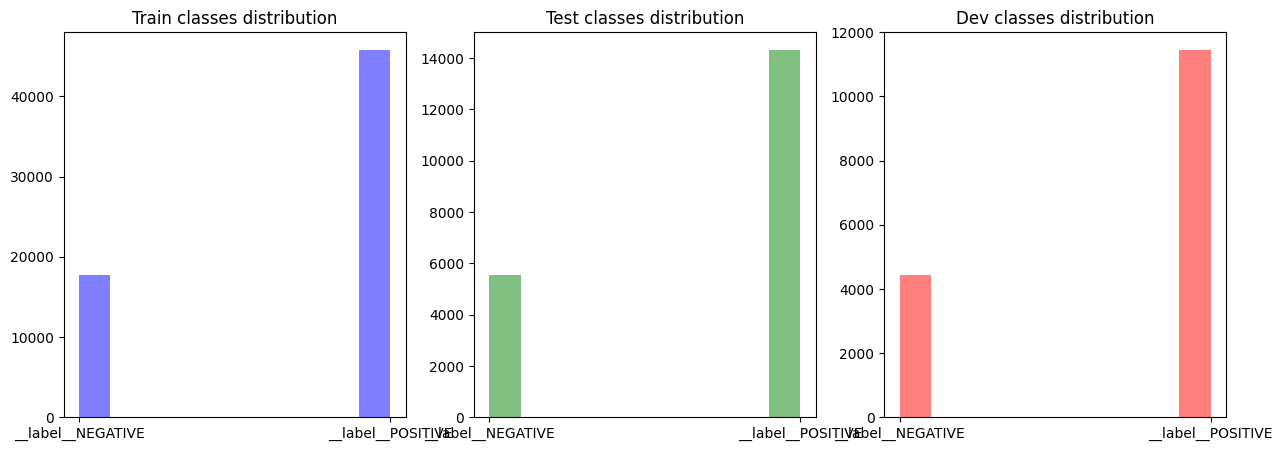

In [151]:
# Création du subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train_bin["Sentiment"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de dev
axs[2].hist(df_val_bin["Sentiment"], color='red', alpha=0.5)
axs[2].set_title('Dev classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test_bin["Sentiment"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()

### 3 Classes

In [152]:
df_train = pd.DataFrame()
df_val = pd.DataFrame()
df_test = pd.DataFrame()

ratio_val = 0.8
ratio_test = 0.8

for sentiment in df["Sentiment"].unique():
    mask = (df["Sentiment"]==sentiment)
    tmp = df.loc[mask].sample(frac=1)
    split_val_index = int(tmp.shape[0] * 0.8*0.8)
    split_test_index = int(tmp.shape[0] * 0.8)
    df_train = pd.concat((df_train, tmp.iloc[:split_val_index]))
    df_val = pd.concat((df_val, tmp.iloc[split_val_index:split_test_index]))
    df_test = pd.concat((df_test, tmp.iloc[split_test_index:]))

print("train set:", df_train.shape)
print("val set:", df_val.shape)
print("test set:", df_test.shape)

train set: (67562, 10)
val set: (16892, 10)
test set: (21114, 10)


In [153]:
outfile_train = os.path.join(DATA_FOLDER, "fasttext_3cls_train.txt")
df_train[["Sentiment", "cleaned_review"]].to_csv(outfile_train, sep=" ", encoding="utf-8")

outfile_val = os.path.join(DATA_FOLDER, "fasttext_3cls_val.txt")
df_val[["Sentiment", "cleaned_review"]].to_csv(outfile_val, sep=" ", encoding="utf-8")

outfile_test = os.path.join(DATA_FOLDER, "fasttext_3cls_test.txt")
df_test[["Sentiment", "cleaned_review"]].to_csv(outfile_test, sep=" ", encoding="utf-8")

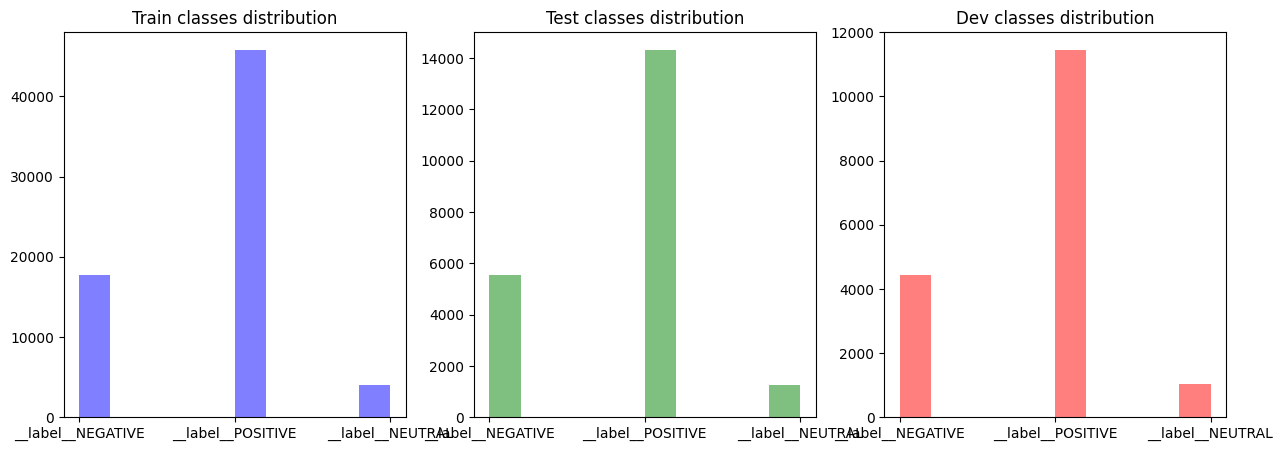

In [154]:
# Création du subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train["Sentiment"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de dev
axs[2].hist(df_val["Sentiment"], color='red', alpha=0.5)
axs[2].set_title('Dev classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test["Sentiment"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()

Text(0.5, 1.0, 'Distribution des classes - trainset')

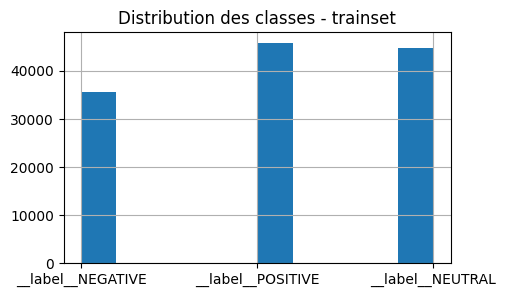

In [155]:
count_pos = df_train["Sentiment"].value_counts()["__label__POSITIVE"]
count_neu = df_train["Sentiment"].value_counts()["__label__NEUTRAL"]
count_neg = df_train["Sentiment"].value_counts()["__label__NEGATIVE"]

ratio_neu = (count_pos-count_neu) // count_neu
ratio_neg = (count_pos-count_neg) // count_neg

mask = (df_train["Sentiment"]=="__label__NEUTRAL")
items = [df_train]+[df_train[mask]]*ratio_neu
df_train = pd.concat(items,ignore_index=True)

mask = (df_train["Sentiment"]=="__label__NEGATIVE")
items = [df_train]+[df_train[mask]*ratio_neg]
df_train = pd.concat(items,ignore_index=True)

fig = plt.figure(figsize=(5,3))
df_train["Sentiment"].hist()
plt.title("Distribution des classes - trainset")


Text(0.5, 1.0, 'Distribution des classes - trainset')

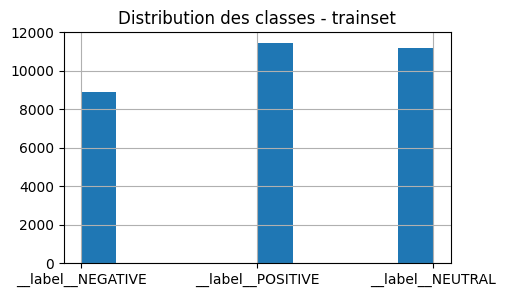

In [156]:
count_pos = df_val["Sentiment"].value_counts()["__label__POSITIVE"]
count_neu = df_val["Sentiment"].value_counts()["__label__NEUTRAL"]
count_neg = df_val["Sentiment"].value_counts()["__label__NEGATIVE"]

ratio_neu = (count_pos-count_neu) // count_neu
ratio_neg = (count_pos-count_neg) // count_neg

mask = (df_val["Sentiment"]=="__label__NEUTRAL")
items = [df_val]+[df_val[mask]]*ratio_neu
df_val = pd.concat(items,ignore_index=True)

mask = (df_val["Sentiment"]=="__label__NEGATIVE")
items = [df_val]+[df_val[mask]*ratio_neg]
df_val = pd.concat(items,ignore_index=True)

fig = plt.figure(figsize=(5,3))
df_val["Sentiment"].hist()
plt.title("Distribution des classes - trainset")

In [157]:
outfile_train_oversampled = os.path.join(DATA_FOLDER, "fasttext_3cls_train_oversampled.txt")
df_train[["Sentiment", "cleaned_review"]].to_csv(outfile_train_oversampled, sep=" ", encoding="utf-8")

outfile_val_oversampled = os.path.join(DATA_FOLDER, "fasttext_3cls_val_oversampled.txt")
df_val[["Sentiment", "cleaned_review"]].to_csv(outfile_val_oversampled, sep=" ", encoding="utf-8")

# Training

In [139]:
LABELS = ['__label__NEGATIVE', '__label__NEUTRAL', '__label__POSITIVE']

def plotCMX(labels, cm):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    ax.set_xticklabels([""]+labels)
    plt.ylabel('Actuals', fontsize=18)
    ax.set_yticklabels([""]+labels)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

## 2 classes

In [216]:
model = fasttext.train_supervised(
    input=outfile_2cls_train,
    verbose=True,
    autotuneValidationFile=outfile_2cls_val)

Progress: 100.0% Trials:   24 Best score:  0.954706 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  136622
Number of labels: 2
Progress: 100.0% words/sec/thread:   21603 lr:  0.000000 avg.loss:  0.327123 ETA:   0h 0m 0s


### Evaluation

/data/DATALAB_PAU/18_HPC/tmp/ipykernel_47035/199692441.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+labels)
/data/DATALAB_PAU/18_HPC/tmp/ipykernel_47035/199692441.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+labels)


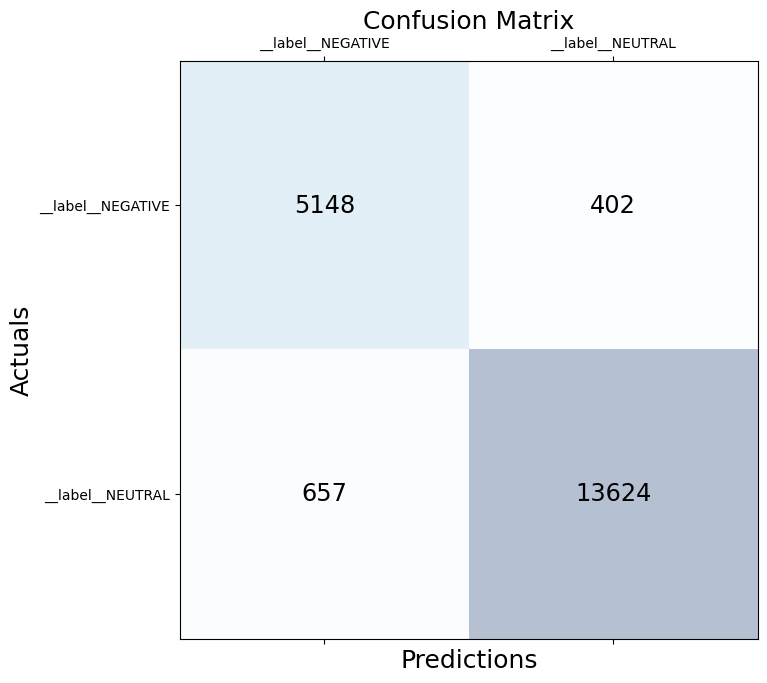

In [217]:
mask = ~(df_test_bin["cleaned_review"].isna())
y_test_bin = df_test_bin.loc[mask, "Sentiment"].tolist()

y_pred_bin = []
for i, text in enumerate(df_test_bin.loc[mask, "cleaned_review"]):
    y_pred_bin += [model.predict(text)[0][0]]

cm = confusion_matrix(y_test_bin, y_pred_bin)
plotCMX(LABELS, cm)

In [218]:
print(classification_report(y_test_bin, y_pred_bin))

                   precision    recall  f1-score   support

__label__NEGATIVE       0.89      0.93      0.91      5550
__label__POSITIVE       0.97      0.95      0.96     14281

         accuracy                           0.95     19831
        macro avg       0.93      0.94      0.93     19831
     weighted avg       0.95      0.95      0.95     19831



In [219]:
mask = ~(df_test_bin["cleaned_review"].isna())
mask_errors = (np.array(y_test_bin)!=np.array(y_pred_bin))
tmp = pd.DataFrame(df_test_bin[mask])

errors = tmp[mask_errors]

errors = pd.DataFrame(errors["star"].value_counts())
values = pd.DataFrame(df_test_bin["star"].value_counts())

errors = errors.merge(values, left_index=True, right_index=True)
errors.columns = ["errors", "total"]

errors["error_rate"] = errors["errors"] / errors["total"]
errors.sort_index()

,errors,total,error_rate
star,,,
1,220,4831,0.045539
2,182,719,0.253129
4,358,3648,0.098136
5,299,10644,0.028091


Text(0.5, 1.0, 'Distributions of companies for errors')

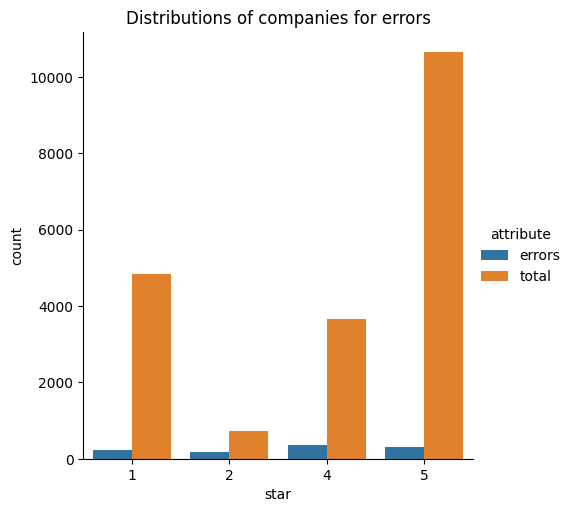

In [220]:
errors = pd.DataFrame(errors[ ["errors", "total"]].stack()).reset_index(drop=False)
errors.columns = ["star", "attribute", "count"]

sns.catplot(data=errors, x="star", y="count", hue="attribute", kind="bar")
plt.title("Distributions of companies for errors")

## 3 classes

In [161]:
model = fasttext.train_supervised(
    input=outfile_train_oversampled,
    verbose=True,
    autotuneValidationFile=outfile_val_oversampled)

Progress: 100.0% Trials:   31 Best score:  0.738671 ETA:   0h 0m 0s
Training again with best arguments
Read 2M words
Number of words:  202546
Number of labels: 3
Progress: 100.0% words/sec/thread:  131725 lr:  0.000000 avg.loss:  0.769130 ETA:   0h 0m 0s


### Evaluation

/data/DATALAB_PAU/18_HPC/tmp/ipykernel_47035/199692441.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+labels)
/data/DATALAB_PAU/18_HPC/tmp/ipykernel_47035/199692441.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+labels)


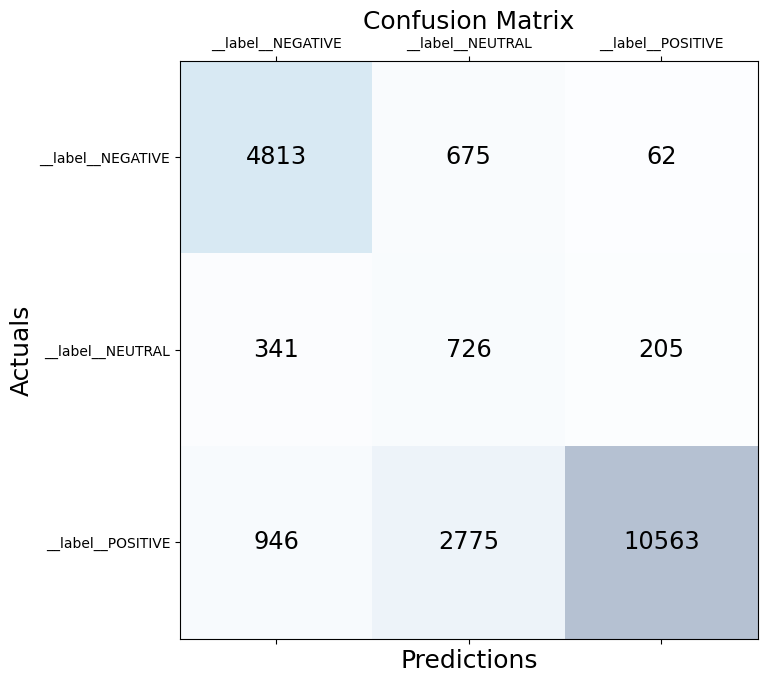

In [162]:
mask = ~(df_test["cleaned_review"].isna())
y_test = df_test.loc[mask, "Sentiment"].tolist()

y_pred = []
for i, text in enumerate(df_test.loc[mask, "cleaned_review"]):
    y_pred += [model.predict(text)[0][0]]

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [163]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

__label__NEGATIVE       0.79      0.87      0.83      5550
 __label__NEUTRAL       0.17      0.57      0.27      1272
__label__POSITIVE       0.98      0.74      0.84     14284

         accuracy                           0.76     21106
        macro avg       0.65      0.73      0.64     21106
     weighted avg       0.88      0.76      0.80     21106



In [208]:
mask_errors = (np.array(y_test)!=np.array(y_pred))
tmp = pd.DataFrame(df_test[mask])

errors = tmp[mask_errors]

errors = pd.DataFrame(errors["company"].value_counts())
values = pd.DataFrame(df_test["company"].value_counts())

errors = errors.merge(values, left_index=True, right_index=True)
errors.columns = ["errors", "total"]

errors["error_rate"] = errors["errors"] / errors["total"]
errors

,errors,total,error_rate
company,,,
CDiscount,4251,17794,0.238901
Amazon,496,1958,0.253320
Fnac,257,1362,0.188693


Text(0.5, 1.0, 'Distributions of companies for errors')

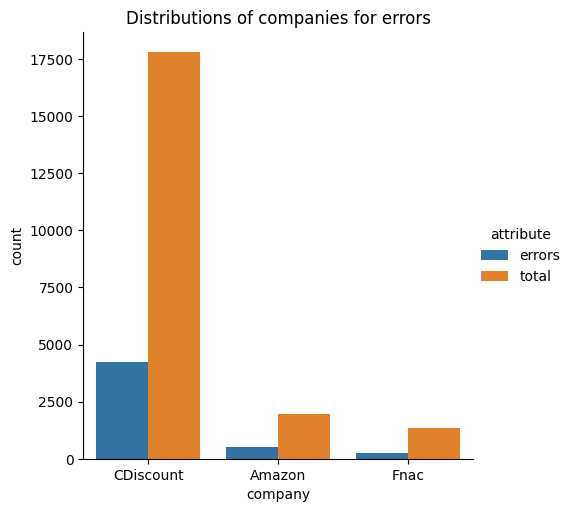

In [209]:
errors = pd.DataFrame(errors[ ["errors", "total"]].stack()).reset_index(drop=False)
errors.columns = ["company", "attribute", "count"]

sns.catplot(data=errors, x="company", y="count", hue="attribute", kind="bar")
plt.title("Distributions of companies for errors")

In [214]:
mask_errors = (np.array(y_test)!=np.array(y_pred))
tmp = pd.DataFrame(df_test[mask])

errors = tmp[mask_errors]

errors = pd.DataFrame(errors["star"].value_counts())
values = pd.DataFrame(df_test["star"].value_counts())

errors = errors.merge(values, left_index=True, right_index=True)
errors.columns = ["errors", "total"]

errors["error_rate"] = errors["errors"] / errors["total"]
errors.sort_index()

,errors,total,error_rate
star,,,
1,454,4802,0.094544
2,283,748,0.378342
3,546,1272,0.429245
4,1475,3629,0.406448
5,2246,10663,0.210635


Text(0.5, 1.0, 'Distributions of companies for errors')

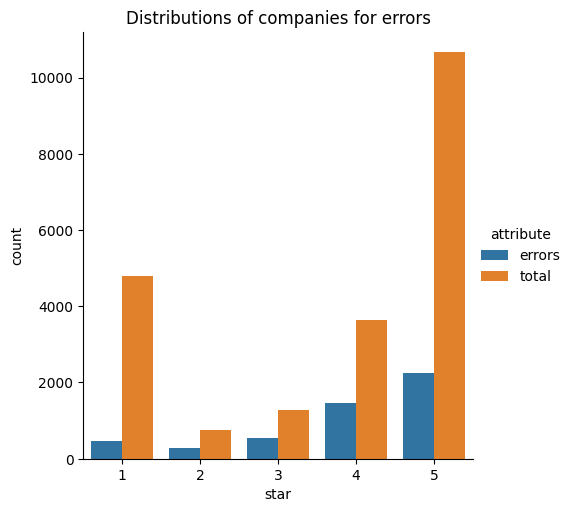

In [215]:
errors = pd.DataFrame(errors[ ["errors", "total"]].stack()).reset_index(drop=False)
errors.columns = ["star", "attribute", "count"]

sns.catplot(data=errors, x="star", y="count", hue="attribute", kind="bar")
plt.title("Distributions of companies for errors")